In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

pd.options.mode.chained_assignment = None  # default='warn'

In [11]:
columns = ['LoanStatus', 'EmploymentStatus', 'CreditScoreRangeLower',
           'CreditScoreRangeUpper', 'LoanOriginalAmount', 'IsBorrowerHomeowner',
            'CurrentDelinquencies', 'AmountDelinquent']

data_unclean = pd.read_csv('prosperLoanData.csv')
data_filtered = data_unclean[columns]
print(data_filtered.shape)


#Converting Loan Status into a binary classification
data_filtered['LoanStatus'] = data_filtered["LoanStatus"].apply(lambda x: 1 if x in["Completed", "Current", "FinalPaymentInProgress"] else 0)

#Converting Booleans to Int
data_filtered['IsBorrowerHomeowner'] = data_filtered['IsBorrowerHomeowner'].apply(lambda x: 1 if x == True else 0)

#Converting Employment Status into a binary classification
data_filtered['EmploymentStatus'] = data_filtered['EmploymentStatus'].apply(lambda x: 1 if x in ['Employed', 'Full-time', 'Self-employed', 'Part-time'] else 0)

data = data_filtered.dropna()

data['CreditScoreAvg'] = (data['CreditScoreRangeLower'] + data['CreditScoreRangeUpper'])/2
data.drop(columns=['CreditScoreRangeUpper', 'CreditScoreRangeLower'], inplace=True)

(113937, 8)


In [15]:
data.head(15)

,LoanStatus,EmploymentStatus,LoanOriginalAmount,IsBorrowerHomeowner,CurrentDelinquencies,AmountDelinquent,CreditScoreAvg
0,1,1,9425,1,2.0,472.0,649.5
1,1,1,10000,0,0.0,0.0,689.5
3,1,1,10000,1,4.0,10056.0,809.5
4,1,1,15000,1,0.0,0.0,689.5
5,1,1,15000,1,0.0,0.0,749.5
6,1,1,3000,0,0.0,0.0,689.5
7,1,1,10000,0,0.0,0.0,709.5
8,1,1,10000,1,0.0,0.0,829.5
9,1,1,10000,1,0.0,0.0,829.5
10,1,1,13500,0,1.0,253.0,649.5


In [5]:
x_train, x_test, y_train, y_test = train_test_split(data.iloc[:, 1:data.shape[1]], data['LoanStatus'], train_size=0.8, shuffle=True, random_state=2)

print(x_train.shape)
print(x_test.shape)

y_train_dist = np.bincount(np.array(y_train))
y_test_dist = np.bincount(np.array(y_test))

# Checking if the distribution of delinquent loans in the test and train datasets is roughly equal
print(y_train_dist[0]/y_train_dist[1]) 
print(y_test_dist[0]/y_test_dist[1]) 

(85052, 6)
(21263, 6)
0.17738586339599657
0.17579075425790755


<h4><code>Visualising how: 1) n_estimators(trees) 2) max_features to consider in each node split affects error rate </code>

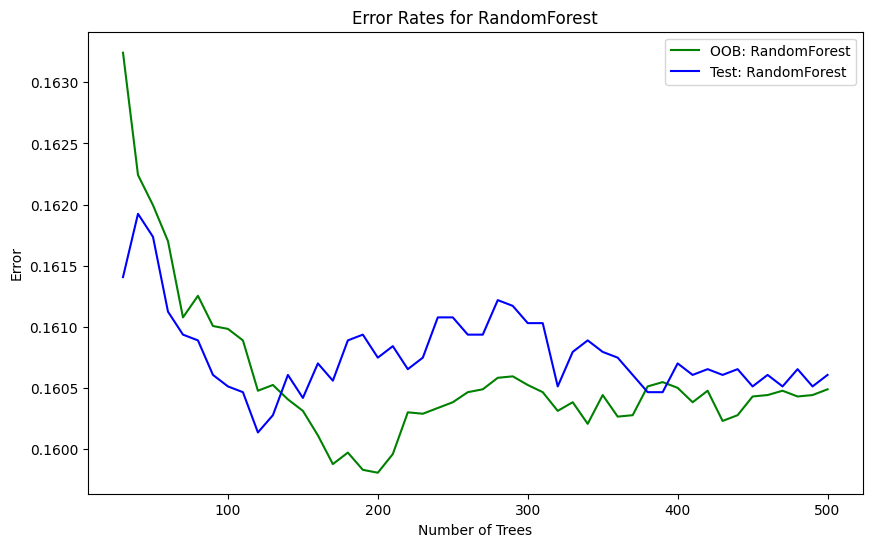

In [106]:
# Lists to store errors
oob_error_rf = []
test_error_rf = []

# Number of trees to evaluate
n_trees = range(30, 501, 10)

# Train RandomForest
for n in n_trees:
    rf = RandomForestClassifier(n_estimators=n, oob_score=True, random_state=42)

    rf.fit(x_train, y_train)

    # Record the OOB and test errors
    oob_error_rf.append(1 - rf.oob_score_)
    test_error_rf.append(1 - rf.score(x_test, y_test))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_trees, oob_error_rf, 'g-', label='OOB: RandomForest')
plt.plot(n_trees, test_error_rf, 'b-', label='Test: RandomForest')
plt.xlabel('Number of Trees')
plt.ylabel('Error')
plt.title('Error Rates for RandomForest')
plt.legend()
plt.show()

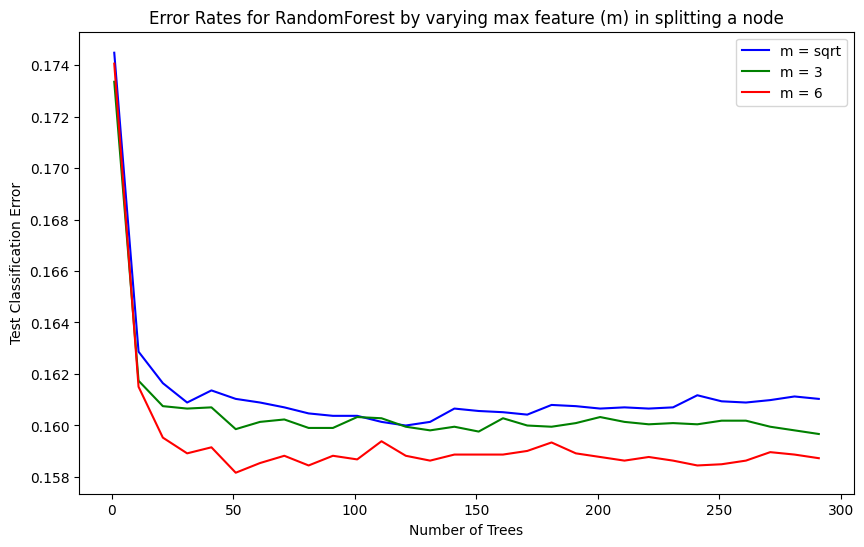

In [65]:
error_dict={}
max_features = ['sqrt', int(x_train.shape[1]/2), x_train.shape[1]]#2,3,6 features are used to split a node

# Number of trees to evaluate
n_trees = range(1, 301, 10)

# Train RandomForest and Bagging models
for feature in max_features:
    test_error_rf = []
    for n in n_trees:
        rf = RandomForestClassifier(n_estimators=n, max_features=feature, random_state=42)
        rf.fit(x_train, y_train)
        
        # Record the OOB and test errors
        test_error_rf.append(1 - rf.score(x_test, y_test))

    error_dict[feature] = test_error_rf

# Colors for plotting
colors = ['blue','green','red']  

plt.figure(figsize=(10, 6))

for feature, color in zip(max_features, colors):
    plt.plot(n_trees, error_dict[feature], color=color, label= 'm = ' + str(feature))

plt.xlabel('Number of Trees')
plt.ylabel('Test Classification Error')
plt.title('Error Rates for RandomForest by varying max feature (m) in splitting a node')
plt.legend()
plt.show()

In [72]:
error_dict

{'sqrt': [0.17448149367445798,
  0.1628650707802286,
  0.16164228942294123,
  0.16088980858768753,
  0.1613601091097211,
  0.16103089874429766,
  0.16088980858768753,
  0.1607016883788741,
  0.16046653811785727,
  0.16037247801345056,
  0.16037247801345056,
  0.16013732775243383,
  0.1599962375958237,
  0.16013732775243383,
  0.1606546583266707,
  0.16056059822226398,
  0.16051356817006068,
  0.16041950806565397,
  0.16079574848328082,
  0.1607487184310774,
  0.1606546583266707,
  0.1607016883788741,
  0.1606546583266707,
  0.1607016883788741,
  0.16117198890090767,
  0.16093683863989094,
  0.16088980858768753,
  0.16098386869209425,
  0.16112495884870437,
  0.16103089874429766],
 3: [0.17335277242157743,
  0.16173634952734794,
  0.1607487184310774,
  0.1606546583266707,
  0.1607016883788741,
  0.1598551474392137,
  0.16013732775243383,
  0.16023138785684055,
  0.159902177491417,
  0.159902177491417,
  0.16032544796124726,
  0.16027841790904385,
  0.1599492075436204,
  0.15980811738701

<h4><code>Random Forest Hyperparameter Search via Cross Validation (k=5)</code>

In [66]:
# Define the model
rf = RandomForestClassifier(random_state=42)

# Setting up the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', int(x_train.shape[1]/2), x_train.shape[1]], #Note: Using all the features is equivalent to the Bagging method.
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Configure GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

# Fit GridSearchCV to the data
grid_search.fit(x_train,y_train)

# Best model
best_rf = grid_search.best_estimator_

# Extract and print the best parameters and the best f-1 score during the k-fold cross validation 
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation f1-score:", grid_search.best_score_)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation f1-score: 0.9194596558198883


In [69]:
best_rf = RandomForestClassifier(n_estimators= 200, max_depth = 10, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split= 2, random_state=42)

In [96]:
best_rf.fit(x_train, y_train)
# make predictions on train and test set
predictions = best_rf.predict(x_test)

# Calculate Accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Calculate Precision
precision = precision_score(y_test, predictions, average='binary')
print("Precision:", precision)

# Calculate Recall
recall = recall_score(y_test, predictions, average='binary')
print("Recall:", recall)

# Calculate F1 Score
f1 = f1_score(y_test, predictions, average='binary')
print("F1 Score:", f1)

print('\n')

# Generate and display the Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:\n", conf_matrix)
# Extracting TN, FP, FN, TP
TN, FP, FN, TP = conf_matrix.ravel()

# Display the extracted values
print("True Negatives (TN):", TN)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)
print("True Positives (TP):", TP)

print('\n')
# Generate a classification report
class_report = classification_report(y_test, predictions)
print("Classification Report:\n", class_report)


Accuracy: 0.8533602972299299
Precision: 0.8576959847036328
Recall: 0.9922030524220306
F1 Score: 0.9200594810788637


Confusion Matrix:
 [[  202  2977]
 [  141 17943]]
True Negatives (TN): 202
False Positives (FP): 2977
False Negatives (FN): 141
True Positives (TP): 17943


Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.06      0.11      3179
           1       0.86      0.99      0.92     18084

    accuracy                           0.85     21263
   macro avg       0.72      0.53      0.52     21263
weighted avg       0.82      0.85      0.80     21263



<h3><code>Random Forest Feature Importance Visualisation</code>

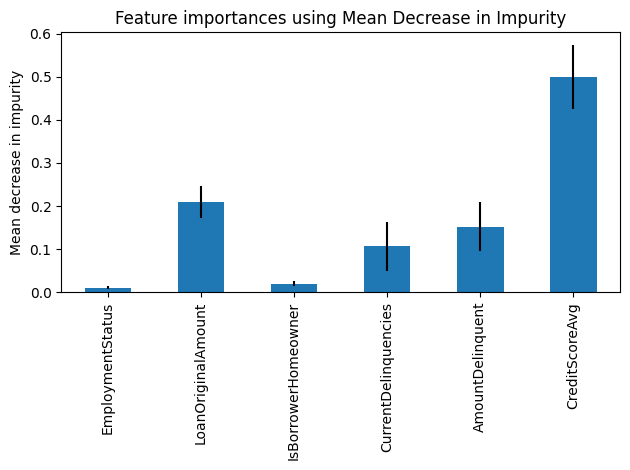

In [94]:
feature_importances = best_rf.feature_importances_
feature_names = x_train.columns

forest_importances = pd.Series(feature_importances, index=feature_names)
standard_deviation = np.std([tree.feature_importances_ for tree in best_rf.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=standard_deviation, ax=ax)
ax.set_title("Feature importances using Mean Decrease in Impurity")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()